In [78]:
# My basic  installation libraries for fNIRS data analysis. Note: Some may not be useful in this analysis.
!pip install mne
!pip install mne-nirs
!pip install pyvistaqt
!pip install ipywidgets
!pip install --upgrade mne-bids[full]
!pip install h5py
!pip install snirf
!pip install fooof

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [79]:
#fNIRS devices consist of two kinds of optodes: light sources (AKA “emitters” or “transmitters”) and light detectors (AKA “receivers”). Channels are defined as source-detector pairs, and channel locations are defined as the midpoint between source and detector.
#upported measurement types include amplitude, optical density, oxyhaemoglobin concentration, and deoxyhemoglobin concentration (for continuous wave fNIRS), and additionally AC amplitude and phase (for frequency domain fNIRS).
#Standardized data SNIRF (.snirf) The Shared Near Infrared Spectroscopy Format (SNIRF) Data stored in the SNIRF format can be read in using mne.io.read_raw_snirf().
#Continuous Wave Devices
  #NIRx (directory or hdr) NIRx produce continuous wave fNIRS devices. NIRx recordings can be read in using mne.io.read_raw_nirx()
  #Hitachi (.csv) Hitachi produce continuous wave fNIRS devices. Hitachi fNIRS recordings can be read using mne.io.read_raw_hitachi()
#Frequency Domain Devices
  #BOXY.BOXY recordings can be read in using mne.io.read_raw_boxy()
  #DC All light collected by the detector (fnirs_cw_amplitude)
  #AC High-frequency modulated light intensity (fnirs_fd_ac_amplitude)
  #Phase Phase of the modulated light (fnirs_fd_phase)

In [80]:
# Shout out to Finger tapping 
#Finger tapping data
fnirs_data_folder = mne.datasets.fnirs_motor.data_path()

In [81]:
#GLM Analysis (measured)
import os
import numpy as np
import matplotlib.pyplot as plt

import mne
import mne_nirs

from mne_nirs.experimental_design import make_first_level_design_matrix
from mne_nirs.statistics import run_glm
from mne_nirs.channels import (get_long_channels,
                               get_short_channels,
                               picks_pair_to_idx)

#from nilearn.plotting import plot_design_matrix

In [82]:
#we analyse data from a real multichannel functional near-infrared spectroscopy (fNIRS) experiment (see GLM Analysis (Simulated) for a simplified simulated analysis). 
#The experiment consists of three conditions:
#tapping with the left hand,
#tapping with the right hand,
#a control condition where the participant does nothing.

#We use a GLM analysis to examine the neural activity associated with the different tapping conditions. 
#An alternative epoching style analysis on the same data can be viewed in the waveform analysis
#Import raw NIRS data

#Clean up annotations before analysis

#Preprocess NIRS data

#View experiment events

#Create design matrix

#Examine expected response

#Fit GLM to subset of data and estimate response for each experimental condition

#Fit GLM to all data and view topographic distribution

#Analyse regions of interest

#Compute contrasts

#Export Results

#Determine true and false positive rates

In [83]:
#import raw NIRS data
fnirs_data_folder = mne.datasets.fnirs_motor.data_path()
fnirs_raw_dir = os.path.join(fnirs_data_folder, 'Participant-1')
raw_intensity = mne.io.read_raw_nirx(fnirs_raw_dir).load_data()
raw_intensity.resample(0.7)

Loading /root/mne_data/MNE-fNIRS-motor-data/Participant-1
Reading 0 ... 23238  =      0.000 ...  2974.464 secs...


<RawNIRX | Participant-1, 56 x 2082 (2972.9 s), ~981 kB, data loaded>

In [84]:
#Clean up annotations before analysis
raw_intensity.annotations.rename({'1.0': 'Control',
                                  '2.0': 'Tapping_Left',
                                  '3.0': 'Tapping_Right'})
raw_intensity.annotations.delete(raw_intensity.annotations.description == '15.0')
raw_intensity.annotations.set_durations(5)

<Annotations | 90 segments: Control (30), Tapping_Left (30), Tapping_Right ...>

In [85]:
#preprocessing of NIRS data
raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od, ppf=0.1)

In [86]:
short_chs = get_short_channels(raw_haemo)
raw_haemo = get_long_channels(raw_haemo)

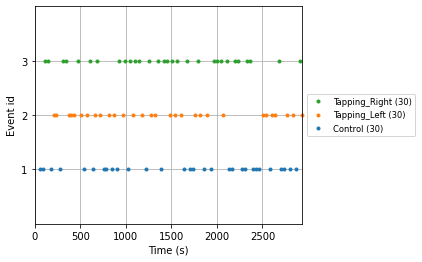

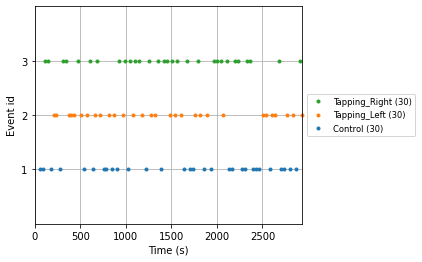

In [87]:
events, event_dict = mne.events_from_annotations(raw_haemo, verbose=False)
mne.viz.plot_events(events, event_id=event_dict, sfreq=raw_haemo.info['sfreq'])

Used Annotations descriptions: ['Control', 'Tapping_Left', 'Tapping_Right']


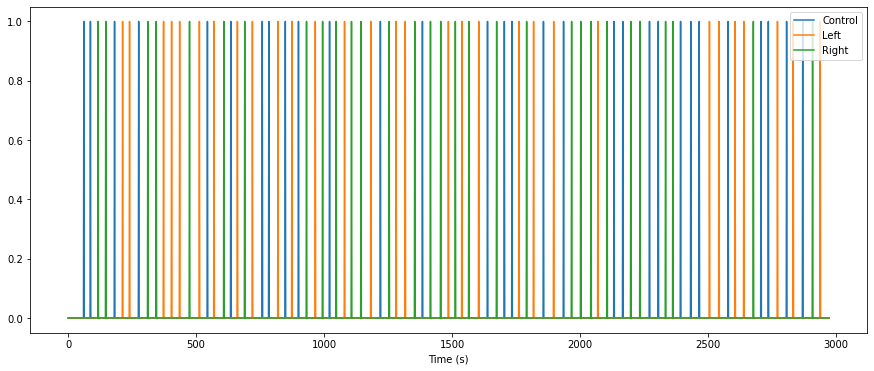

In [88]:
s = mne_nirs.experimental_design.create_boxcar(raw_haemo)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
plt.plot(raw_haemo.times, s, axes=axes)
plt.legend(["Control", "Left", "Right"], loc="upper right")
plt.xlabel("Time (s)");

In [89]:
design_matrix = make_first_level_design_matrix(raw_haemo,
                                               drift_model='cosine',
                                               high_pass=0.005,  # Must be specified per experiment
                                               hrf_model='spm',
                                               stim_dur=5.0)

In [90]:
design_matrix["ShortHbO"] = np.mean(short_chs.copy().pick(
                                    picks="hbo").get_data(), axis=0)

design_matrix["ShortHbR"] = np.mean(short_chs.copy().pick(
                                    picks="hbr").get_data(), axis=0)

Used Annotations descriptions: ['Control', 'Tapping_Left', 'Tapping_Right']


Text(0, 0.5, 'Amplitude')

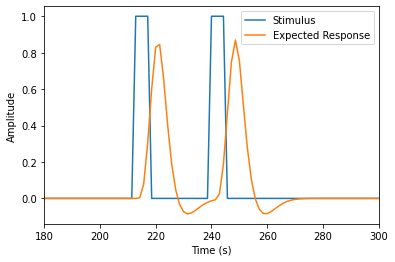

In [91]:
#examine expected response
s = mne_nirs.experimental_design.create_boxcar(raw_intensity, stim_dur=5.0)
plt.plot(raw_intensity.times, s[:, 1])
plt.plot(design_matrix['Tapping_Left'])
plt.xlim(180, 300)
plt.legend(["Stimulus", "Expected Response"])
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

In [92]:
#Fit GLM to subset of data and estimate response for each experimental condition
data_subset = raw_haemo.copy().pick(picks=range(2))
glm_est = run_glm(data_subset, design_matrix)

In [93]:
glm_est

GLM Results for 2 channels

In [94]:
glm_est.copy().pick('S1_D1 hbr')

GLM Results for 1 channels

In [95]:
glm_est.MSE()

[3.6359501281260763e-11, 9.482010775760916e-12]

In [96]:
#and we can chain the methods to quickly access required details. For example, to determine the MSE for channel S1 D1 for the hbr type you would call:
glm_est.copy().pick('S1_D1 hbr').MSE()

[9.482010775760916e-12]

In [97]:
#demonstrated and then we just display the first 9 rows of the table which correspond to the 9 components of the design matrix for the first channel.
glm_est.to_dataframe().head(9)

variable,Condition,df,mse,p_value,se,t,theta,Source,Detector,Chroma,Significant,ch_name
0,Control,35.0,3.635950e-11,5.703922e-01,1.271854e-06,0.572874,7.286122e-07,1,1,hbo,False,S1_D1 hbo
1,ShortHbO,35.0,3.635950e-11,5.988346e-39,1.253564e-02,68.802806,8.624875e-01,1,1,hbo,True,S1_D1 hbo
2,ShortHbR,35.0,3.635950e-11,2.051290e-19,7.976514e-02,-18.187656,-1.450741e+00,1,1,hbo,True,S1_D1 hbo
3,Tapping_Left,35.0,3.635950e-11,8.464418e-06,1.289978e-06,5.211297,6.722461e-06,1,1,hbo,True,S1_D1 hbo
4,Tapping_Right,35.0,3.635950e-11,7.547857e-16,1.294997e-06,13.935896,1.804694e-05,1,1,hbo,True,S1_D1 hbo
5,constant,35.0,3.635950e-11,5.227182e-02,2.943860e-07,-2.009249,-5.914949e-07,1,1,hbo,False,S1_D1 hbo
6,drift_1,35.0,3.635950e-11,6.333101e-25,3.084314e-05,26.818114,8.271549e-04,1,1,hbo,True,S1_D1 hbo
7,drift_10,35.0,3.635950e-11,8.211815e-07,1.215036e-05,5.979676,7.265522e-05,1,1,hbo,True,S1_D1 hbo
8,drift_11,35.0,3.635950e-11,4.069713e-01,1.242152e-05,0.839347,1.042596e-05,1,1,hbo,False,S1_D1 hbo


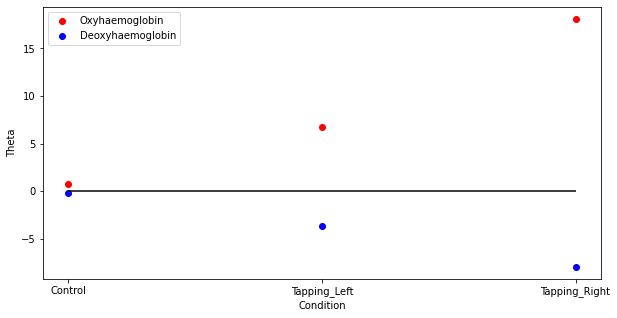

In [98]:
glm_est.scatter()

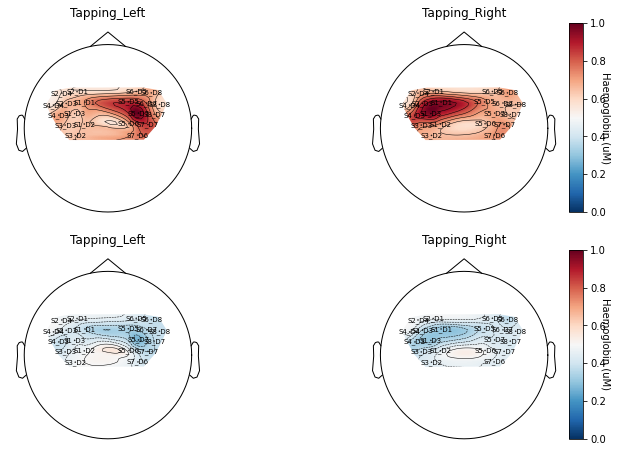

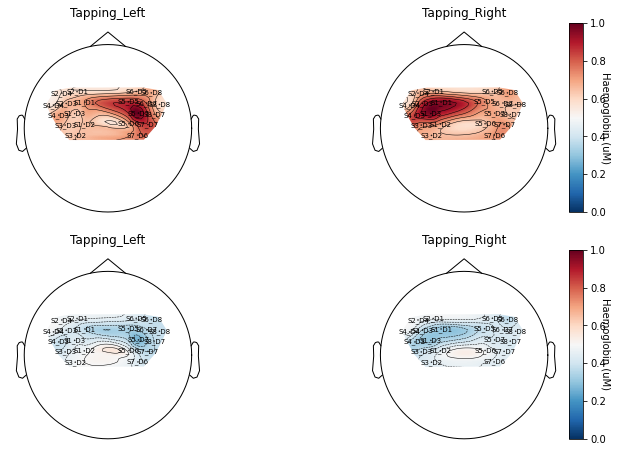

In [99]:
#Fit GLM to all data and view topographic distribution
glm_est = run_glm(raw_haemo, design_matrix)
glm_est.plot_topo(conditions=['Tapping_Left', 'Tapping_Right'])

Text(0.5, 1.0, 'Hemispheres plotted independently')

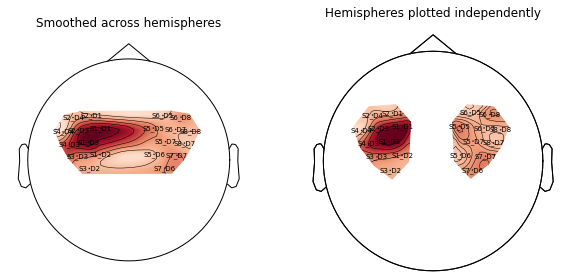

In [100]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), gridspec_kw=dict(width_ratios=[0.92, 1]))

glm_hbo = glm_est.copy().pick(picks="hbo")
conditions = ['Tapping_Right']

glm_hbo.plot_topo(axes=axes[0], colorbar=False, conditions=conditions)

glm_hbo.copy().pick(picks=range(10)).plot_topo(conditions=conditions, axes=axes[1], colorbar=False, vlim=(-16, 16))
glm_hbo.copy().pick(picks=range(10, 20)).plot_topo(conditions=conditions, axes=axes[1], colorbar=False, vlim=(-16, 16))

axes[0].set_title("Smoothed across hemispheres")
axes[1].set_title("Hemispheres plotted independently")

In [101]:
#Another way to view the data is to project the GLM estimates to the nearest cortical surface
#glm_est.copy().surface_projection(condition="Tapping_Right", view="dorsal", chroma="hbo")

In [102]:
#Analyse regions of interest (ROI)
left = [[1, 1], [1, 2], [1, 3], [2, 1], [2, 3],
        [2, 4], [3, 2], [3, 3], [4, 3], [4, 4]]
right = [[5, 5], [5, 6], [5, 7], [6, 5], [6, 7],
         [6, 8], [7, 6], [7, 7], [8, 7], [8, 8]]

groups = dict(Left_ROI=picks_pair_to_idx(raw_haemo, left),
              Right_ROI=picks_pair_to_idx(raw_haemo, right))

conditions = ['Control', 'Tapping_Left', 'Tapping_Right']

df = glm_est.to_dataframe_region_of_interest(groups, conditions)

In [103]:
df

,ROI,Condition,Chroma,theta,se,t,dfe,p,Weighted
0,Left_ROI,Control,hbo,-1.690850e-07,0.906548,-0.186515,35,8.531176e-01,Inverse standard error
1,Left_ROI,Control,hbr,1.621215e-07,0.510929,0.317307,35,7.528959e-01,Inverse standard error
2,Right_ROI,Control,hbo,3.814778e-08,0.941335,0.040525,35,9.679047e-01,Inverse standard error
3,Right_ROI,Control,hbr,-1.034544e-07,0.532735,-0.194195,35,8.471461e-01,Inverse standard error
0,Left_ROI,Tapping_Left,hbo,4.808888e-06,0.919870,5.227791,35,8.051619e-06,Inverse standard error
1,Left_ROI,Tapping_Left,hbr,-1.837941e-06,0.518407,-3.545361,35,1.136272e-03,Inverse standard error
2,Right_ROI,Tapping_Left,hbo,9.219006e-06,0.955125,9.652143,35,2.123476e-11,Inverse standard error
3,Right_ROI,Tapping_Left,hbr,-3.877839e-06,0.540531,-7.174123,35,2.280434e-08,Inverse standard error
0,Left_ROI,Tapping_Right,hbo,9.738244e-06,0.922471,10.556691,35,2.015806e-12,Inverse standard error
1,Left_ROI,Tapping_Right,hbr,-3.240867e-06,0.519857,-6.234145,35,3.799977e-07,Inverse standard error


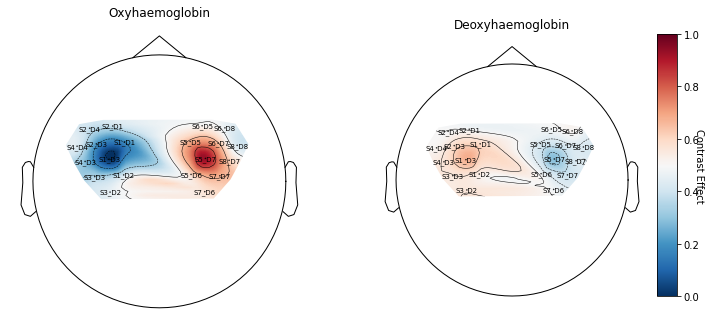

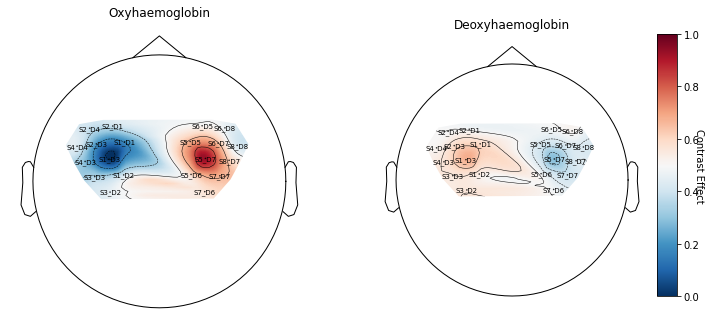

In [104]:
contrast_matrix = np.eye(design_matrix.shape[1])
basic_conts = dict([(column, contrast_matrix[i])
                   for i, column in enumerate(design_matrix.columns)])
contrast_LvR = basic_conts['Tapping_Left'] - basic_conts['Tapping_Right']

contrast = glm_est.compute_contrast(contrast_LvR)
contrast.plot_topo()

In [105]:
#export results
df = glm_est.to_dataframe()

In [106]:
df

variable,Condition,df,mse,p_value,se,t,theta,Source,Detector,Chroma,Significant,ch_name
0,Control,35.0,1.214297e-11,4.713574e-01,0.000001,0.728163,7.767152e-07,1,1,hbo,False,S1_D1 hbo
1,ShortHbO,35.0,1.214297e-11,1.181445e-44,0.008238,100.328915,8.264767e-01,1,1,hbo,True,S1_D1 hbo
2,ShortHbR,35.0,1.214297e-11,8.997220e-26,0.053564,-28.426520,-1.522633e+00,1,1,hbo,True,S1_D1 hbo
3,Tapping_Left,35.0,1.214297e-11,2.519371e-08,0.000001,7.140427,7.728608e-06,1,1,hbo,True,S1_D1 hbo
4,Tapping_Right,35.0,1.214297e-11,2.913915e-16,0.000001,14.386071,1.561573e-05,1,1,hbo,True,S1_D1 hbo
...,...,...,...,...,...,...,...,...,...,...,...,...
1395,drift_5,35.0,1.491726e-11,8.900824e-03,0.000050,2.770405,1.395917e-04,8,8,hbr,True,S8_D8 hbr
1396,drift_6,35.0,1.491726e-11,1.217067e-02,0.000050,2.644302,1.328702e-04,8,8,hbr,True,S8_D8 hbr
1397,drift_7,35.0,1.491726e-11,9.923290e-01,0.000050,0.009683,4.846988e-07,8,8,hbr,False,S8_D8 hbr
1398,drift_8,35.0,1.491726e-11,1.554665e-01,0.000050,1.451787,7.255342e-05,8,8,hbr,False,S8_D8 hbr


In [107]:
#Determine true and false positive rates
(df
 .query('Condition in ["Control", "Tapping_Left", "Tapping_Right"]')
 .drop(['df', 'mse', 'p_value', 't'], axis=1)
 .groupby(['Condition', 'Chroma', 'ch_name'])
 .agg(['mean'])
 )

variable                                  se         theta Source Detector  \
                                        mean          mean   mean     mean   
Condition     Chroma ch_name                                                 
Control       hbo    S1_D1 hbo  1.066677e-06  7.767152e-07    1.0      1.0   
                     S1_D2 hbo  7.491500e-07 -4.497856e-08    1.0      2.0   
                     S1_D3 hbo  7.672949e-07  4.646158e-07    1.0      3.0   
                     S2_D1 hbo  6.342857e-07 -5.627240e-07    2.0      1.0   
                     S2_D3 hbo  8.390797e-07  8.605292e-07    2.0      3.0   
...                                      ...           ...    ...      ...   
Tapping_Right hbr    S6_D8 hbr  7.334896e-07 -4.239772e-06    6.0      8.0   
                     S7_D6 hbr  6.292325e-07 -1.893321e-06    7.0      6.0   
                     S7_D7 hbr  4.903269e-07 -2.039497e-06    7.0      7.0   
                     S8_D7 hbr  6.149382e-07 -2.704977e-06    8.0      7.0   
                     S8_D8 hbr  1.203101e-06 -2.265968e-06    8.0      8.0   

variable                       Significant  
                                      mean  
Condition     Chroma ch_name                
Control       hbo    S1_D1 hbo         0.0  
                     S1_D2 hbo         0.0  
                     S1_D3 hbo         0.0  
                     S2_D1 hbo         0.0  
                     S2_D3 hbo         0.0  
...                                    ...  
Tapping_Right hbr    S6_D8 hbr         1.0  
                     S7_D6 hbr         1.0  
                     S7_D7 hbr         1.0  
                     S8_D7 hbr         1.0  
                     S8_D8 hbr         0.0  

[120 rows x 5 columns]